# Abstract:

Ce projet traite du problème des attaques adverses sur des systèmes de reconnaissance faciale. Il s'agit d'un domaine pour lequel les activités de recherches sont très actives dans la mesure où les systèmes de reconnaissance faciale sont de plus en plus utilisés comme méthodes d'authentification.

La première partie de cette étude consistera à développer un classifieur $C$. Ce classifieur $C$ doit retrouver l'identité d'une personne figurant sur une image (*face identification*). La configuration *closed-set* sera utilisée : toutes les identités dans l'ensemble de test sont présentes dans l'ensemble d'entraînement.

La deuxième partie portera sur la conception d'un modèle adverse $A$ qui attaque les images fournies au classifieur $C$.  $A$ doit générer un bruit $B_{pert}$, qui fausse la classification de $C$, tel que la différence entre l'image perturbée $I_{pert} = I_{origin} + B_{pert}$ et l'image d'origine $I_{origin}$ ne soit pas perceptible à l'oeil nu.

Pour ce projet, j'ai choisi d'utiliser framework PyTorch ainsi que le jeu de données LFW (*Labeled Faces in the Wild*) qui contient 13233 images de visages de 5749 personnes.

---------------------------------

Les parties **Chargement des données**, **Analyse de la distribution du jeu de données** de ce notebook peuvent être lancées directement. 

La partie **Entrainement** contient les blocs de codes pour l'entrainement des classifieurs ad hoc et pré entrainés. Les paramètres des modèles entrainés ont été stockés dans des fichiers au format .pt :


*   classifier_adhoc.pt : paramètres du classifier ad hoc entraîné
*   classifier_adhoc_with_noise.pt : paramètres du classifier ad hoc entraîné avec un bruit gaussien additif
*   pretrained_classifier_vgg16 : paramètres du classifier pré-entraîné VGG16
*   robust_classifier_adhoc.pt : paramètres du classifier entraîné avec des attaques adverses (adversarial training)


La partie **Attaques** commence par le chargement des paramètres des modèles entrainés à partir des fichiers .pt. Elle traite ensuite de l'évaluation des modèles ainsi que des attaques.

## Chargement des données

In [1]:
!pip install pytorch_metric_learning

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
torch.cuda.empty_cache()
import torchvision
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
from torchvision.datasets import LFWPeople
import matplotlib.pyplot as plt
import torchvision.models as models
import math
import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F


print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

save_path = f"/content/drive/MyDrive/projetDL_img/"

preprocess = transforms.Compose([
    transforms.ToTensor(),
])

lfw_data = LFWPeople(root="./", download=True,transform=preprocess)

CUDA Available:  False
Files already downloaded and verified


# Analyse de la distribution du jeu de données
------------
Dans un premier temps, nous allons analyser la distribution du jeu de données.

- Premièrement, la documentation de [LFW](http://vis-www.cs.umass.edu/lfw/) précise qu'il existe des erreurs d'annotations dans le jeu : 6 paires sont mals annotées.

- La documentation indique que l'on a 1680 personnes qui ont au moins 2 images d'eux dans le dataset. En d'autres termes, parmi les 5749 identités, seulement 1680  peuvent avoir au moins un exemple dans le *train set* et le *test set*. Je décide donc de ne conserver que ces 1680 identités car pour les autres il n'y a pas de moyen d'évaluer les performances du modèle. 

Nombre d'identités avec au moins 2 échantillons:  1680


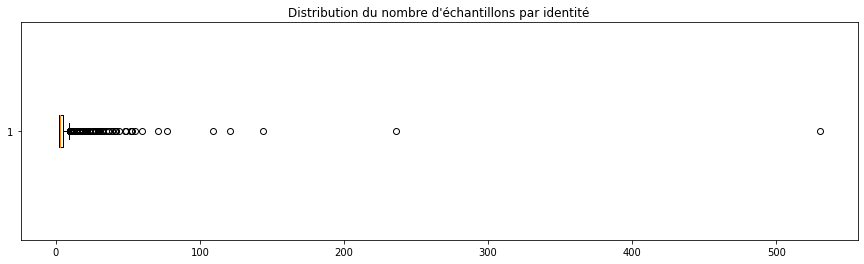

Premier quantile (25%):  2
Troisième quantile (75%) :  5
Dernier décile (90%) :  9


In [3]:
import pandas as pd

min_sample_per_class = 2

df = pd.DataFrame({"index": np.arange(len(lfw_data.targets)), "target": lfw_data.targets})

# Table de fréquence des identités
target_count = df.groupby("target").size().reset_index().rename(columns={0:"count"})

# On ne conserve que les identités avec au moins 2 échantillons
target_count = target_count[(target_count["count"] >= min_sample_per_class)]
df = df.merge(target_count, on="target", how="inner") 

df.head()

print("Nombre d'identités avec au moins 2 échantillons: ",\
target_count.target.nunique())


plt.figure(figsize = (15,4))
plt.title("Distribution du nombre d'échantillons par identité")
plt.boxplot(target_count["count"],vert=False)
plt.show()


print("Premier quantile (25%): ", round(np.percentile(target_count["count"], 25)))
print("Troisième quantile (75%) : ", round(np.percentile(target_count["count"], 75)))
print("Dernier décile (90%) : ", round(np.percentile(target_count["count"], 90)))

Après avoir conservé les identités avec au moins 2 échantillons, on constate que le jeu de données est assez déséquilibré. 90% des classes ont moins de 9 échantillons et quelques classes possèdent plus de 100 échantillons. Le cas le plus extrême est la classe "George W. Bush" qui contient 530 échantillons.

Dans la suite, j'ai décidé de conserver les identités qui ont entre 25 et 150 échantillons. Cela permet de réduire le nombre de classes et d'accélérer le processus d'entraînement du classifieur ad hoc. J'ai fait ce choix car ce projet porte principalement sur l'impact des attaques sur la classification et non sur le problème de *face identication* en lui-même.

Je choisis également d'effectuer un découpage stratifié des données de telle sorte que la distribution des identités soit la même dans les bases d’apprentissage et d'évaluation.

In [4]:
import pandas as pd

MIN_SAMPLE_PER_CLASS = 25
MAX_SAMPLE_PER_CLASS = 150


def filter_least_populated_classes(dataset, min_sample_per_class=2, max_sample_per_class=100):
  """Filtrage du dataset pour filtrer les identités en fonction 
  de leur nombres d'échantillons"""
  lfw_df = pd.DataFrame({"index": range(len(dataset.targets)), "target": dataset.targets})

  target_count = lfw_df.groupby("target").size().reset_index().rename(columns={0:"count"})

  target_count = target_count[(target_count["count"] >= min_sample_per_class) & (target_count["count"] <= max_sample_per_class)]
  
  target_count["new_class_name"] = range(len(target_count))
  
  mapping = {k:v for k,v in zip(target_count.target,target_count.new_class_name)}

  lfw_df = lfw_df.merge(target_count, on="target", how="inner") 
  lfw_df.index = lfw_df["index"]
  return lfw_df,mapping

df_lfw_mapping,mapping = filter_least_populated_classes(lfw_data,MIN_SAMPLE_PER_CLASS,MAX_SAMPLE_PER_CLASS)

In [5]:
idx_to_class = {v:k for k,v in lfw_data.class_to_idx.items()}
idx_to_class = {mapping[idx]:name for idx,name in idx_to_class.items() if idx in mapping}

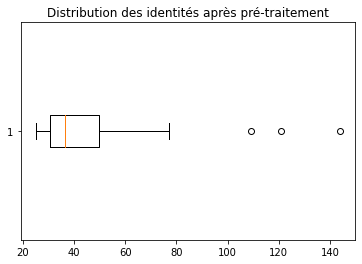

In [6]:
distrib = df_lfw_mapping.groupby("new_class_name").size()
plt.title("Distribution des identités après pré-traitement")
plt.boxplot(distrib,vert=False)
plt.show()

J'ai ensuite mis en place un objet LFW qui permet d'itérer sur les données LFW selon plusieurs modes :
- face identification : le dataset renvoie une image et son identité
- contrastif simple : le dataset renvoie deux images et un booléen indiquant s'il s'agit de la même personne
- contrastif triple : le dataset renvoie 3 images dont
   - l'image d'une personne (ancre)
   - une autre image de la même personne (positif)
   - une image d'une autre personne (négatif)

Il est possible de générer 3 types de triplets :
- *easy triplets* : triplets avec une fonction de cout à 0 car $d(a,p) + margin < d(a,n)$ où $d(x,y)$ est la distance (cosinus, L2...) entre les images $x$ et $y$
- *hard triplets* : triplets où l'exemple négatif est plus proche de l'ancre que l'exemple positif
- *semi-hard triplets* : triplets où l'exemple négatif n'est pas plus proche de l'ancre que l'exemple positif mais engendre quand même un coup positif car $d(a, p) < d(a, n) < d(a, p) + margin$




In [7]:
from torch.utils.data import Dataset

class Lfw(Dataset):
    """Dataset LFW    
     Possibilité de générer les données sous la forme: 
       IMG - IDENTITE
       IMG1 - IMG2 - IS_SAME
       IMG - POSITIVE_IMG - NEGATIVE_IMG"""
    def __init__(self,lfw_data, df_lfw_mapping, preprocess=None, input_size=224):
      self.lfw_data = lfw_data
      self.df = df_lfw_mapping

      self.preprocess_ = preprocess

      self.mode = "train"
      self.preprocess_mode = True

    def __len__(self):
      return len(self.df)

    def set_training_mode(self,mode):
      self.mode = mode

    def enable_preprocess(self,preprocess_mode):
      self.preprocess_mode = preprocess_mode



    def preprocess(self, img):
      if self.preprocess_mode:
        return self.preprocess_(img)
      return img  

    def __getitem__(self, idx):    
      img, target = self.lfw_data[idx]    

      # img = self.preprocess(img) 

      target = int(self.df.loc[idx]["new_class_name"])

      if self.mode == "one":
        return self.preprocess(img), target     
      elif self.mode == "triple":

          same_identity_index = np.random.choice(list(self.df[(self.df["new_class_name"] == target) & (self.df["index"] != idx)]["index"]))
          img1, _ = self.lfw_data[same_identity_index] 
          img1 = self.preprocess(img1)           

          other_identity_index = np.random.choice(list(self.df[  (self.df["new_class_name"] != target)]["index"]))
          img2, _ = self.lfw_data[other_identity_index]
          img2 = self.preprocess(img2) 

          return self.preprocess(img), img1, img2

      elif self.mode == "double":          
          same_identity = np.random.rand() > 0.5

          if same_identity:
            index = np.random.choice(list(self.df[(self.df["new_class_name"] == target) & (self.df["index"] != idx)]["index"]))
            img1, _ = self.lfw_data[index] 
            img1 = self.preprocess(img1)  

            return img, img1, 1.0
          else:        
            index = np.random.choice(list(self.df[  (self.df["new_class_name"] != target)]["index"]))
            img2, _ = self.lfw_data[index]
            img2 = self.preprocess(img2) 
            return img, img2, 0.0
      else:
        raise NameError('Mode inconnu')

Concernant le pré-traitement des images, voici les principales étapes pour l'entrainement:
- RandomCrop (200 x 200)
- RandomHorizontalFlip
<!-- - Normalisation sur les canaux RGB -->


Pour les images d'évaluations :
- CenterCrop (200 x 200)
<!-- - Normalisation sur les canaux RGB -->

Certains articles proposent de normaliser les valeurs des pixels selon les canaux RGB comme ci-dessous. Néanmoins, au vu des objectifs du projets, j'ai décidé de ne pas utiliser cette normalisation. Les valeurs des pixels restent ainsi comprises entre 0 et 1. De cette façon, avec les couleurs d'origine, il sera plus facile de voir si la perturbation est visible ou non à l'oeil nu.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


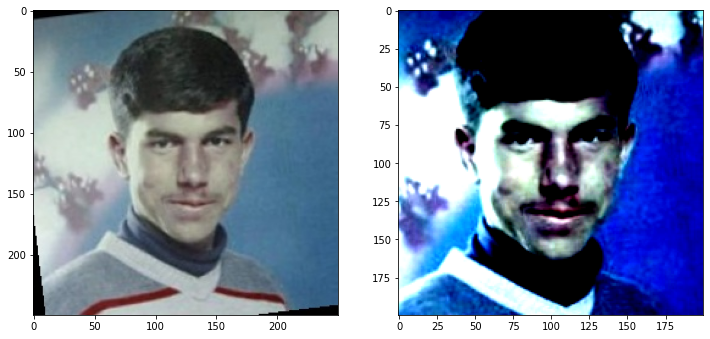

In [8]:
img, target = lfw_data[0]
RGB_MEAN = [ 0.485, 0.456, 0.406 ]
RGB_STD = [ 0.229, 0.224, 0.225 ]
transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(250),                                      
                transforms.CenterCrop(200),
                transforms.ToTensor(),  
                transforms.Normalize(mean=RGB_MEAN,
                                     std=RGB_STD) 
                ])
norm_img = transform(img)
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(norm_img.permute(1,2,0))
plt.show()

J'ai choisi de faire un découpage stratifié avec 10% du dataset alloué pour l'évaluation. J'avais envisagé dans un premier temps d'évaluer le modèle avec la méthode de cross-validation, cependant elle se révèle coûteuse dans le cadre de l'apprentissage profond.

In [9]:
from sklearn.model_selection import train_test_split

input_size = 200
val_ratio = 0.1


RGB_MEAN = [ 0.485, 0.456, 0.406 ]
RGB_STD = [ 0.229, 0.224, 0.225 ]

train_transform = transforms.Compose([
                        transforms.ToPILImage(),
                transforms.Resize(250),
                                      
                transforms.RandomCrop(input_size),
                transforms.RandomHorizontalFlip(),                
                transforms.ToTensor(),  
                # transforms.Normalize(mean=RGB_MEAN,
                #                      std=RGB_STD) 
                ])

test_transform = transforms.Compose([
        transforms.ToPILImage(),
                transforms.Resize(250),

        transforms.CenterCrop(input_size),
        transforms.ToTensor(),  
        # transforms.Normalize(mean=RGB_MEAN, 
        #                      std=RGB_STD)  
    ])

train_idx, valid_idx = train_test_split(
                list(df_lfw_mapping["index"]),
                test_size=val_ratio,
                shuffle=True,
                stratify=list(df_lfw_mapping.new_class_name))

# On sauvergarde les indices du train et test set pour pouvoir continuer l'entrainement
# par la suite

# with open('/content/drive/MyDrive/projetDL_img/train_test_idx2.npy', 'wb') as f:
#     np.save(f, np.array(train_idx))
#     np.save(f, np.array(valid_idx))

with open('./train_test_indexes.npy', 'rb') as f:
    train_idx = np.load(f)
    valid_idx = np.load(f)


train_df = df_lfw_mapping.loc[train_idx]
val_df = df_lfw_mapping.loc[valid_idx]

train_lfw_dataset = Lfw(lfw_data,train_df,preprocess = train_transform)
val_lfw_dataset = Lfw(lfw_data,val_df,preprocess = test_transform)

On vérifie que toutes nos classes sont bien représentées dans l'ensemble d'apprentissage et de test.

In [10]:
train_num_classes = train_lfw_dataset.df.new_class_name.nunique()
print("Nombre de classes dans le jeu d'entrainement: ", train_num_classes)
print("Nombre d'échantillons d'entrainement: ", len(train_lfw_dataset))
print("-"*120)
val_num_classes = val_lfw_dataset.df.new_class_name.nunique()
print("Nombre de classes dans le jeu de test: ", val_num_classes)
print("Nombre d'échantillons de test: ", len(val_lfw_dataset))

assert val_num_classes == train_num_classes

Nombre de classes dans le jeu d'entrainement:  40
Nombre d'échantillons d'entrainement:  1639
------------------------------------------------------------------------------------------------------------------------
Nombre de classes dans le jeu de test:  40
Nombre d'échantillons de test:  183


Avec l'échantillonnage stratifié, toutes les identités sont bien à la fois dans l'ensemble d'entraînement et de test.

On vérifie que le mode de prétraitement fonctionne correctement :

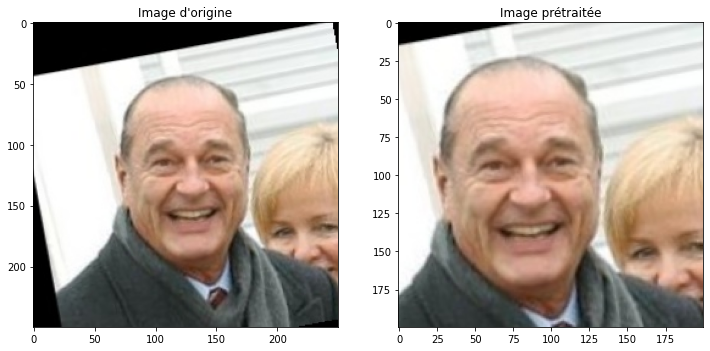

In [11]:
train_lfw_dataset.set_training_mode("one")
train_lfw_dataset.enable_preprocess(False)

img, target = train_lfw_dataset[train_idx[15]]

plt.figure(figsize=(12,12))
plt.title("")
ax = plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
ax.set_title("Image d'origine")

train_lfw_dataset.enable_preprocess(True)

img, target = train_lfw_dataset[train_idx[15]]
ax = plt.subplot(1,2,2)
plt.imshow(img.permute(1,2,0))
ax.set_title("Image prétraitée")

plt.show()

On vérifie que le mode d'échantillonage pour l'entraînement contrastif triple :  

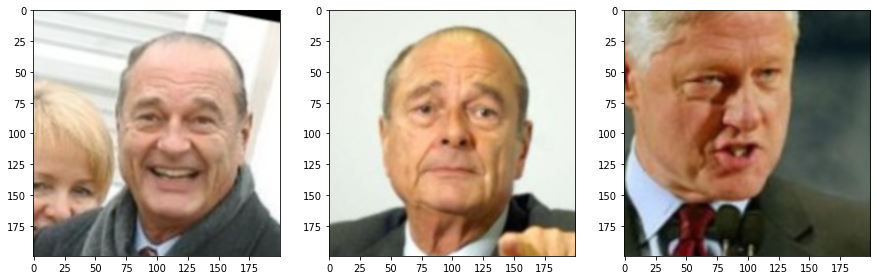

In [12]:
train_lfw_dataset.set_training_mode("triple")
train_lfw_dataset.enable_preprocess(True)

img,img1, img2 = train_lfw_dataset[train_idx[15]]

plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.imshow(img.permute(1,2,0), interpolation="bicubic")
plt.subplot(1,3,2)
plt.imshow(img1.permute(1,2,0), interpolation="bicubic")
plt.subplot(1,3,3)
plt.imshow(img2.permute(1,2,0), interpolation="bicubic")
plt.show()

On vérifie que le mode d'échantillonage pour l'entraînement contrastif double :  

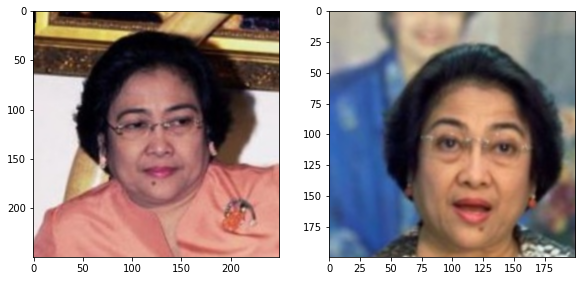

is it the same person ?: True


In [13]:
train_lfw_dataset.set_training_mode("double")

img1,img2, same = train_lfw_dataset[train_idx[31]]

plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.imshow(transforms.ToPILImage()(img1), interpolation="bicubic")
plt.subplot(1,3,2)
plt.imshow(transforms.ToPILImage()(img2), interpolation="bicubic")
plt.show()

print("is it the same person ?:", bool(same))

On vérifie que les images sont bien triées par identité dans le nouveau dataset :

In [14]:
def plot_images_identity(identity, lfw_dataset,N=5):
  res = lfw_dataset.df.groupby("new_class_name")["index"].apply(list).reset_index()
  idxs = list(res[res.new_class_name==identity]["index"])[0]
  plt.figure(figsize=(15,8))
  for i,img_idx in enumerate(idxs[:N]): 
    img, _ = lfw_dataset[img_idx]
    plt.subplot(1,N,i+1)
    plt.imshow(transforms.ToPILImage()(img), interpolation="bicubic")

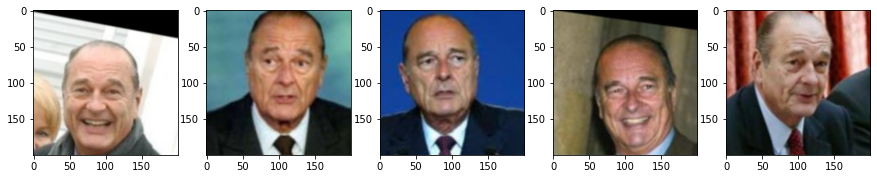

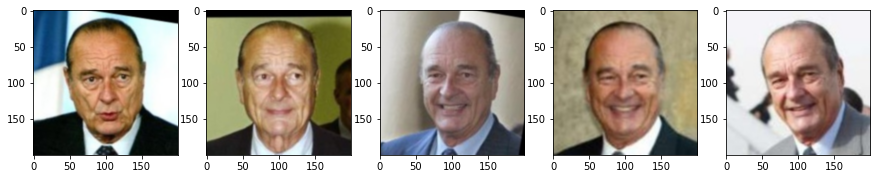

In [15]:
train_lfw_dataset.set_training_mode("one")
val_lfw_dataset.set_training_mode("one")
train_lfw_dataset.enable_preprocess(True)
val_lfw_dataset.enable_preprocess(True)
plot_images_identity(15, train_lfw_dataset,N=5)
plot_images_identity(15, val_lfw_dataset,N=5)

On choisit une taille de batch de 32 pour l'entrainement des modèles.

In [16]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Taille du batch
BATCH_SIZE = 32

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_lfw_dataset,batch_size=BATCH_SIZE, sampler=train_sampler,num_workers=8)
val_loader = DataLoader(val_lfw_dataset,batch_size=BATCH_SIZE, sampler=valid_sampler,num_workers=8)

# Entrainement
------------------------
 Dans cette partie, les modèles ad hoc et pré-entrainés sont entrainés pour classer les images LFW par identité.
 Il y a principalement 2 approches d'entraînement : avec fonction de coût contrastive et avec fonction de coût softmax.

 Pour ce projet, l'approche softmax a été sélectionnée pour l'entrainement du classifieur final (deuxième approche). Les tentatives de l'approche contrastive ont été résumées dans la partie "première approche".


## Première approche : approche contrastive
---------------------




J'ai dans un premier temps commencé par adopter une approche contrastive pour la construction du classifieur $C$. Le premier modèle était un modèle siamois.

J'ai essayé d'utiliser les métriques de distance L2 puis la similarité cosinus.

Concernant la fonction de côut, j'ai d'abord considéré la fonction contrastive simple (2 images), puis la fonction de coût contrastive triplet (ancre, positif, négatif).

Pour chaque paire ou triplets d'images, le réseau siamois applique un encodeur construit à partir d'une architecture résiduelle ResNet50 ou ResNet101. J'ai également essayé avec un modèle WideResNet.

Après avoir entraîné l'encodeur, je l'ai évalué en appliquant un seuil sur la distance entre les vecteurs de deux images. Cela m'a permis de classer des paires d'images de l'ensemble de test comme étant la même personne ou non. 
J'ai ensuite entrainé un multiperceptron à projeter les caractéristiques extraites d'une image sur les classes d'identité.

L'exactitude et le score F1 étaient meilleurs que l'aléatoire mais restaient assez faibles.
Cela s'explique peut être par un problème au niveau de l'implémentation et/ou du réglage des hyperparamètres (marge par exemple) ou par le fait que le nombre d'échantillons n'est pas suffisant pour entrainer la fonction de cout contrastive.

Ci-dessous, on retrouve les modèles siamois à base de similarité cosinus et de distance euclidienne.

In [18]:
import torchvision.models as models

class ContrastiveLoss_Cosine(torch.nn.Module):
    def __init__(self, margin=0.25):
        super(ContrastiveLoss_Cosine, self).__init__()
        self.margin = margin

    def forward(self, y_true, y_pred):
      return torch.mean((y_true) * torch.pow(1 - y_pred, 2) +
                                    (1-y_true) * torch.pow(torch.clamp(self.margin - y_pred, min=0.0), 2))

class SiameseNetwork_Cosine(nn.Module):
    def __init__(self,encoder):
        super(SiameseNetwork_Cosine, self).__init__()
        self.encoder = encoder  

    def forward(self, input1, input2):
        z1 = self.encoder(input1)
        z2 = self.encoder(input2)
        return nn.CosineSimilarity(dim=1, eps=1e-6)(z1,z2)

class ContrastiveLoss_Distance(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss_Distance, self).__init__()

        self.margin = margin

    def forward(self, o1, o2, label):
      euclidean_distance = F.pairwise_distance(o1, o2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

      return loss_contrastive

class SiameseNetwork_Distance(nn.Module):
    def __init__(self, encoder, embedding_dim=512):
        super(SiameseNetwork_Distance, self).__init__()

        self.encoder = encoder
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features, embedding_dim)       
        self.fc1 = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(inplace=True),

            nn.Dropout(p=0.2),
            
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(inplace=True),
            
            nn.Linear(embedding_dim,embedding_dim)
        )
        
    def forward_classification(self, x):
        output = self.encoder(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_classification(input1)
        output2 = self.forward_classification(input2)
        return output1, output2

encoder = models.resnet18(pretrained=False)
siamese = SiameseNetwork_Distance(encoder).to(device)

In [19]:
train_lfw_dataset.enable_preprocess(True)
train_lfw_dataset.set_training_mode("double")

val_lfw_dataset.enable_preprocess(True)
val_lfw_dataset.set_training_mode("double")

EMBED_DIM = 256

encoder = models.resnet18(pretrained=False)
siamese = SiameseNetwork_Distance(encoder,
                                  embedding_dim=EMBED_DIM).to(device)

optimizer = optim.Adam(siamese.parameters(), lr = 0.005 )
criterion = ContrastiveLoss_Distance()

In [ ]:
import torch.nn.functional as F


for epoch in range(100):
    loss_value = 0.0
    siamese.train()
    for i, (img0, img1, label) in enumerate(train_loader):

        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        optimizer.zero_grad()
        output1, output2 = siamese(img0, img1)

        loss_contrastive = criterion(output1, output2, label)

        loss_contrastive.backward()

        loss_value += loss_contrastive.item()

        optimizer.step()

    loss_value /= len(train_loader.dataset)

    siamese.eval()
    val_loss_value = 0
    with torch.no_grad():
      for i, (img0, img1, label) in enumerate(val_loader):

          img0, img1, label = img0.to(device), img1.to(device), label.to(device)

          output1, output2 = siamese(img0, img1)

          loss_contrastive = criterion(output1, output2, label)

          val_loss_value += loss_contrastive.item()

    
    val_loss_value /= len(train_loader.dataset)
    print(f"Epoch {epoch}\n , train loss: {loss_value}, test loss :{val_loss_value}\n")

Ci-dessous, on retrouve la tentative avec un réseau siamois avec une couche sigmoid en sortie. Les vecteurs des deux images sont normalisés (batchnorm) et concaténés pour former un troisième vecteur. Ce dernier est connecté à une couche dense pour calculer la similarité (avec la fonction sigmoid). La fonction de coût choisie est la Binary Cross Entropy pour entrainer le réseau à prédire s'il s'agit de la même personne ou non.

In [22]:
class SiameseNetwork_BCE(nn.Module):
    def __init__(self,encoder, embedding_dim=256):
        super(SiameseNetwork_BCE, self).__init__()
        self.encoder = encoder

        self.bn = nn.BatchNorm1d(embedding_dim)

        self.encoder.fc = nn.Sequential(
          nn.Linear(self.encoder.fc.in_features, embedding_dim),
          nn.ReLU(),
          self.bn            
        )         
        self.fc =   nn.Linear(2*embedding_dim, 1)

    def forward(self, input1, input2):
        output1 = self.encoder(input1)
        output2 = self.encoder(input2)

        # concaténation des deux vecteurs
        concat = torch.cat((output1, output2), 1)
        output = self.fc(concat)

        # On renvoit une valeur de similarité entre 0 et 1
        output = torch.sigmoid(output)
        return output

In [23]:
train_lfw_dataset.enable_preprocess(True)
train_lfw_dataset.set_training_mode("double")

val_lfw_dataset.enable_preprocess(True)
val_lfw_dataset.set_training_mode("double")

EMBED_DIM = 256

encoder = models.resnet18(pretrained=False)
siamese = SiameseNetwork_BCE(encoder,
                            embedding_dim=EMBED_DIM).to(device)

optimizer = optim.Adam(siamese.parameters(), lr = 0.005 )
criterion = nn.BCELoss()

In [24]:
import torch.nn.functional as F

for epoch in range(100):
    loss_value = 0.0
    siamese.train()
    for i, (img0, img1, label) in enumerate(train_loader):

        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        optimizer.zero_grad()
        out = siamese(img0, img1)

        loss_bce = criterion(out, label.unsqueeze(1).float())

        loss_bce.backward()

        loss_value += loss_bce.item()

        optimizer.step()

    loss_value /= len(train_loader.dataset)

    siamese.eval()
    val_loss_value = 0
    with torch.no_grad():
      for i, (img0, img1, label) in enumerate(val_loader):

          img0, img1, label = img0.to(device), img1.to(device), label.to(device)

          out = siamese(img0, img1)

          loss_bce = criterion(out,label.unsqueeze(1).float())

          val_loss_value += loss_bce.item()
    
    val_loss_value /= len(train_loader.dataset)
    print(f"Epoch {epoch}\n , train loss: {loss_value}, test loss :{val_loss_value}\n")

## Deuxième approche : approche softmax
-------------------
Au vu des difficultés dans la première approche, je me suis ensuite tourné vers une approche avec une fonction de coût softmax pour directement entrainer le classifieur à reconnaitre l'identité d'une personne.



Pour évaluer le modèle, j'ai choisi d'utiliser le score F1 macro car nous en sommes en présence d'un jeu de données très déséquilibré. Je conserve également la métrique d'exactitude pour une évaluation des performances globales du modèle.

Dans la suite, j'ai conservé l'approche avec la fonction Softmax car l'implémentation de la fonction ArcFace ne donnait pas des résultats satisfaisants de classification.

### Avec ArcFace
-----------------


In [17]:
class CNN_Classifier_Arcfaceloss(nn.Module):
    def __init__(self,num_classes,embedding_dim = 512):
        super(CNN_Classifier_Arcfaceloss, self).__init__()
        self.backbone = models.resnet101(pretrained=False)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, embedding_dim)

    def forward(self, x):
        embeddings = self.backbone(x)
        return embeddings

class ArcFaceLoss(nn.Module):
    def __init__(self, in_feature=128, out_feature=10575,
                 s=32.0, m=0.50, easy_margin=False):
        super(ArcFaceLoss, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.s = s
        self.m = m
        self.weight = Parameter(torch.Tensor(out_feature, in_feature))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)

        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, x, label):
        cosine = F.linear(F.normalize(x), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where((cosine - self.th) > 0, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output = output * self.s

        return output

In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

def test_arfaceloss(classifier,arcloss, loader):
  classifier.eval()
  preds, targets = [] , []
  val_accuracy = 0.0
  with torch.no_grad():
    for img, target in tqdm(loader):
      img = img.to(device)
      target = target.to(device)

      raw_logits = classifier(img)
      out = arcloss(raw_logits,target)


      pred = [x.item() for x in out.argmax(1)]
      target = [x.item() for x in target]

      preds.extend(pred)
      targets.extend(target)
    
    print("Test accuracy : ", accuracy_score(targets,preds))
    print("F1 score : ", f1_score(targets,preds,average="macro"))
  
  return preds,targets

def train_classifier_arfaceloss(params,train_lfw_dataset, val_lfw_dataset, train_loader,val_loader, optimizer,classifier,criterion, save_path,arcloss=None):
    """returns trained model"""   
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, verbose=True)

    train_lfw_dataset.enable_preprocess(True)
    train_lfw_dataset.set_training_mode("one")

    val_lfw_dataset.enable_preprocess(True)
    val_lfw_dataset.set_training_mode("one")

    
    for epoch in range(1, params["n_epochs"]+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        classifier.train()
        for batch_idx, (image,target) in tqdm(enumerate(train_loader)):
            
            image = image.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            raw_logits = classifier(image)

            out = arcloss(raw_logits,target)

            loss = criterion(out,target)
            loss.backward()
            optimizer.step()   
            train_loss += loss.item()
          
        train_loss /= len(train_loader.dataset)


        ###  VALIDATION
        with torch.no_grad():
          classifier.eval()

          for batch_idx, (image,target) in enumerate(val_loader):
              
              image = image.to(device)
              target = target.to(device)

              raw_logits = classifier(image)
              out = arcloss(raw_logits,target)

              loss = criterion(out,target)
              valid_loss += loss.item()
              
          valid_loss /= len(val_loader.dataset)
        
          current_lr = optimizer.param_groups[0]['lr']
          scheduler.step()

          print("Epoch: {}, lr = {}  ,training loss = {}, val_loss = {}".format(epoch, current_lr, train_loss, valid_loss))
          test_arfaceloss(classifier, arcloss,val_loader)

In [20]:
from pytorch_metric_learning import losses
EMB_DIM = 512

criterion = nn.CrossEntropyLoss().to(device)

arcloss = ArcFaceLoss(EMB_DIM,train_num_classes).to(device)
model_with_arcfaceloss = CNN_Classifier_Arcfaceloss(train_num_classes,EMB_DIM).to(device)

In [ ]:
optimizer = optim.SGD([
        {'params': model_with_arcfaceloss.parameters(), 'weight_decay': 5e-4},
        {'params': arcloss.parameters(), 'weight_decay': 5e-4}
        ] , 
                      lr=0.01,
                      momentum=0.9,
                      weight_decay = 5e-4)

params = {
    "n_epochs":50
}
save_path = f"./"

train_classifier_arfaceloss(params,train_lfw_dataset,
                 val_lfw_dataset, 
                 train_loader,
                 val_loader, 
                 optimizer,model_with_arcfaceloss,criterion, save_path,arcloss=arcloss)

### Avec Softmax
---------------------------------
Cette section consiste à entraîner le modèle avec la fonction de sortie softmax et la fonction de coût Categorical Cross Entropy.

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

def test(classifier, loader, verbose=False):
  """Cette fonction permet d'évaluer les performances
  d'un modèle de classification : accuracy et score f1"""
  classifier.eval()
  preds, targets = [] , []
  val_accuracy = 0.0
  with torch.no_grad():
    for img, target in tqdm(loader):
      img = img.to(device)
      target = target.to(device)

      raw_logits = classifier(img)

      pred = [x.item() for x in raw_logits.argmax(1)]
      target = [x.item() for x in target]

      if verbose:
        print("pred",pred)
        print("target",target)

      preds.extend(pred)
      targets.extend(target)
    
    test_acc = accuracy_score(targets,preds)
    score_f1 = f1_score(targets,preds,average="macro")

    if verbose:
      print("Test accuracy : ", test_acc)
      print("F1 score : ", score_f1)
  
  return preds,targets,test_acc,score_f1

def train_classifier(params,train_lfw_dataset, val_lfw_dataset, train_loader,val_loader, optimizer,classifier,criterion, save_path):
    """Cette fonction permet d'entraîner un modèle au problème d'identification faciale"""   
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    train_lfw_dataset.enable_preprocess(True)
    train_lfw_dataset.set_training_mode("one")

    val_lfw_dataset.enable_preprocess(True)
    val_lfw_dataset.set_training_mode("one")

    
    for epoch in range(1, params["n_epochs"]+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        classifier.train()
        preds, targets = [] , []

        for batch_idx, (image,target) in tqdm(enumerate(train_loader)):
            

            if params["transform"]:
              image = params["transform"](image)


            image = image.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            raw_logits = classifier(image)

            loss = criterion(raw_logits,target)
            loss.backward()
            optimizer.step()   
            train_loss += loss.item()

            with torch.no_grad():
              pred =   [x.item() for x in raw_logits.argmax(1)]
              target = [x.item() for x in target]

              preds.extend(pred)
              targets.extend(target)
          
        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(targets,preds)


        ###  VALIDATION
        with torch.no_grad():
          classifier.eval()

          for batch_idx, (image,target) in enumerate(val_loader):
              
              image = image.to(device)
              target = target.to(device)

              raw_logits = classifier(image)

              loss = criterion(raw_logits,target)
              valid_loss += loss.item()
              
          valid_loss /= len(val_loader.dataset)
        
          current_lr = optimizer.param_groups[0]['lr']
          scheduler.step(valid_loss)

          preds,targets,test_acc,score_f1 = test(classifier,val_loader)
          print(" ### Epoch: {}, lr = {}, train_acc = {},training loss = {},test_acc = {}, val_loss = {}".format(epoch, current_lr,train_acc, train_loss, test_acc,valid_loss))

L'architecture du modèle ad hoc choisi est une structure avec des blocs résiduels "Bottleneck". La structure résiduelle permet de propager le gradient plus facilement à travers les couches du réseau. Chaque bloc résiduel est constitué d'une couche convolutionnelle avec un filtre de taille 1 puis une couche convolutionnelle avec un filtre de taille 3 et enfin une couche convolutionnelle avec un filtre de taille 1. 
Le dernier plan est applati et connecté à une couche de sortie linéaire.

In [24]:
layers_config = [
    [2, 64, 5, 2],
    [4, 128, 1, 2],
    [2, 128, 6, 1],
    [4, 128, 1, 2],
    [2, 128, 2, 1]
]


class BottleNeckBlock(nn.Module):
    def __init__(self, inp, oup, stride, expansion):
        super(BottleNeckBlock, self).__init__()
        self.connect = stride == 1 and inp == oup

        self.conv = nn.Sequential(
            # 1 x 1 CONV
            nn.Conv2d(inp, inp * expansion, 1, 1, 0, bias=False),
            nn.BatchNorm2d(inp * expansion),
            nn.PReLU(inp * expansion),

            # 3 x 3 DEPTHWISE CONV
            nn.Conv2d(inp * expansion, inp * expansion, 3, stride, 1, groups=inp * expansion, bias=False),
            nn.BatchNorm2d(inp * expansion),
            nn.PReLU(inp * expansion),

            # 1 x 1 CONV
            nn.Conv2d(inp * expansion, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        )

    def forward(self, x):
        if self.connect:
            return x + self.conv(x)
        else:
            return self.conv(x)



class ConvLayer(nn.Module):
    def __init__(self, input, output, kernel_size, stride, padding, dw=False, use_linear=False):
        super(ConvLayer, self).__init__()
        self.use_linear = use_linear
        if dw:
            self.conv = nn.Conv2d(input, output, kernel_size, stride, padding, groups=input, bias=False)
        else:
            self.conv = nn.Conv2d(input, output, kernel_size, stride, padding, bias=False)

        self.bn = nn.BatchNorm2d(output)
        if not use_linear:
            self.prelu = nn.PReLU(output)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.use_linear:
            return x
        else:
            return self.prelu(x)


class ModelAdHoc(nn.Module):
    def __init__(self, class_num,feature_dim=128, layers_config=layers_config):
        super(ModelAdHoc, self).__init__()
        self.conv1 = ConvLayer(3, 64, 3, 2, 1)
        self.depth_wise_conv1 = ConvLayer(64, 64, 3, 1, 1, dw=True)

        self.cur_channel = 64
        block = BottleNeckBlock
        self.blocks = self._make_layer(block, layers_config)

        self.conv2 = ConvLayer(128, 512, 1, 1, 0)
        self.linear7 = ConvLayer(512, 512, 7, 1, 0, dw=True, use_linear=True)
        self.linear1 = ConvLayer(512, feature_dim, 1, 1, 0, use_linear=True)
        self.projection = nn.Linear(9800 ,class_num)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, setting):
        layers = []
        for t, c, n, s in setting:
            for i in range(n):
                if i == 0:
                    layers.append(block(self.cur_channel, c, s, t))
                else:
                    layers.append(block(self.cur_channel, c, 1, t))
                self.cur_channel = c

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.depth_wise_conv1(x)
        x = self.blocks(x)
        x = self.conv2(x)
        x = self.linear7(x)
        x = self.linear1(x)
        x = x.view(x.size(0), -1)

        x = nn.Dropout(p=0.2)(x)
        x = self.projection(x)

        return x

In [25]:
from pytorch_metric_learning import losses
EMB_DIM = 200

criterion = nn.CrossEntropyLoss().to(device)
model = ModelAdHoc(class_num=train_num_classes,feature_dim=EMB_DIM).to(device)

Entraînemenet du modèle ad hoc : 

In [ ]:
optimizer = optim.SGD([
        {'params': model.parameters(), 'weight_decay': 5e-4},
        ] , 
                      lr=0.0005,
                      momentum=0.9,
                      weight_decay = 5e-4)

params = {
    "n_epochs":50,
    "transform" : None
}

train_classifier(params,train_lfw_dataset,
                 val_lfw_dataset, 
                 train_loader,
                 val_loader, 
                 optimizer,model,criterion, save_path)

Sauvegarde du modèle ad hoc entraîné :

In [ ]:
# torch.save(model.state_dict(), save_path+"classifier_adhoc.pt")

Le modèle ad hoc a également été entrainé avec des images auxquelles on ajoute un bruit gaussien (0 ; 0.05). Le bruit gaussien additif peut être vu comme une méthode de data augmentation.

In [27]:
from pytorch_metric_learning import losses
EMB_DIM = 200

criterion = nn.CrossEntropyLoss().to(device)
model_with_noise = ModelAdHoc(class_num=train_num_classes,feature_dim=EMB_DIM).to(device)

In [ ]:
from torchvision.transforms import Lambda
optimizer = optim.SGD([
        {'params': model_with_noise.parameters(), 'weight_decay': 5e-4},
        ] , 
                      lr=0.001,
                      momentum=0.9,
                      weight_decay = 5e-4)


class AddGaussianNoise(object):
    """Bruit gaussien additif"""
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

transform=transforms.Compose([
    AddGaussianNoise(0., 0.05),
    Lambda(lambda x: torch.clamp(x,0,1))
])

params = {
    "n_epochs":50,
    "transform" : transform
}

train_classifier(params,train_lfw_dataset,
                 val_lfw_dataset, 
                 train_loader,
                 val_loader, 
                 optimizer,
                 model_with_noise,
                 criterion, save_path)

Sauvegarde du modèle ad hoc entraîné :

In [45]:
# torch.save(model_with_noise.state_dict(), save_path+"classifier_adhoc_with_noise.pt")

## Modèle pré-entrainé (VGG16)

Cette section consiste à entrainé sur quelques epochs un modèle pré-entrainé VGG16. J'ai choisi d'utiliser le module torchvision de Pytorch pour l'implémentation du modèle préentrainé VGG16.

Nous commençons par appliquer les pré-traitements attendus sur les images pour VGG16 (redimensionnement, normalisation sur les canaux RGB).
Le calcul du gradient par rapport aux paramètres des premières couches du modèle est désactivé (*freeze*). 


In [2]:
from pytorch_metric_learning import losses
EMB_DIM = 200

criterion = nn.CrossEntropyLoss()
pretrained_model = models.vgg16(pretrained=True)

for param in pretrained_model.features.parameters():
  param.requires_grad = False

in_features = pretrained_model.classifier[-1].in_features
pretrained_model.classifier[-1] = nn.Sequential(    
nn.Linear(in_features,in_features),
nn.ReLU(),
nn.Dropout(p=0.2),
nn.Linear(in_features,train_num_classes)

)

pretrained_model = pretrained_model.to(device)

NameError: name 'nn' is not defined

In [ ]:
optimizer = optim.SGD([
        {'params': pretrained_model.parameters(), 'weight_decay': 5e-4},
        ] , 
                      lr=0.001,
                      momentum=0.9,
                      weight_decay = 5e-4)




params = {
    "n_epochs":50,
    "transform" : None
}

train_classifier(params,train_lfw_dataset,
                 val_lfw_dataset, 
                 train_loader,
                 val_loader, 
                 optimizer,
                 pretrained_model,criterion, save_path)

Sauvegarde du modèle pré-entrainé après le *fine-tuning*.

In [26]:
torch.save(pretrained_model.state_dict(), save_path+"pretrained_classifier_vgg16.pth")

# Attaques

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix


from pytorch_metric_learning import losses
EMB_DIM = 200

criterion = nn.CrossEntropyLoss()
pretrained_model = models.vgg16(pretrained=True)
# for param in pretrained_model.features.parameters():
#   param.requires_grad = False

in_features = pretrained_model.classifier[-1].in_features
pretrained_model.classifier[-1] = nn.Sequential(    
nn.Linear(in_features,in_features),
nn.ReLU(),
nn.Dropout(p=0.2),
nn.Linear(in_features,train_num_classes)

)

pretrained_model = pretrained_model.to(device)

def test(classifier, loader, verbose=False):
  classifier.eval()
  preds, targets = [] , []
  val_accuracy = 0.0
  with torch.no_grad():
    for img, target in tqdm(loader):
      img = img.to(device)
      target = target.to(device)

      raw_logits = classifier(img)

      pred = [x.item() for x in raw_logits.argmax(1)]
      target = [x.item() for x in target]

      if verbose:
        print("pred",pred)
        print("target",target)

      preds.extend(pred)
      targets.extend(target)
    
    test_acc = accuracy_score(targets,preds)
    score_f1 = f1_score(targets,preds,average="macro")

    if verbose:
      print("Test accuracy : ", test_acc)
      print("F1 score : ", score_f1)
  
  return preds,targets,test_acc,score_f1

layers_config = [
    [2, 64, 5, 2],
    [4, 128, 1, 2],
    [2, 128, 6, 1],
    [4, 128, 1, 2],
    [2, 128, 2, 1]
]

class BottleNeckBlock(nn.Module):
    def __init__(self, inp, oup, stride, expansion):
        super(BottleNeckBlock, self).__init__()
        self.connect = stride == 1 and inp == oup

        self.conv = nn.Sequential(
            # 1 x 1 CONV
            nn.Conv2d(inp, inp * expansion, 1, 1, 0, bias=False),
            nn.BatchNorm2d(inp * expansion),
            nn.PReLU(inp * expansion),

            # 3 x 3 DEPTHWISE CONV
            nn.Conv2d(inp * expansion, inp * expansion, 3, stride, 1, groups=inp * expansion, bias=False),
            nn.BatchNorm2d(inp * expansion),
            nn.PReLU(inp * expansion),

            # 1 x 1 CONV
            nn.Conv2d(inp * expansion, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        )

    def forward(self, x):
        if self.connect:
            return x + self.conv(x)
        else:
            return self.conv(x)



class ConvLayer(nn.Module):
    def __init__(self, input, output, kernel_size, stride, padding, dw=False, use_linear=False):
        super(ConvLayer, self).__init__()
        self.use_linear = use_linear
        if dw:
            self.conv = nn.Conv2d(input, output, kernel_size, stride, padding, groups=input, bias=False)
        else:
            self.conv = nn.Conv2d(input, output, kernel_size, stride, padding, bias=False)

        self.bn = nn.BatchNorm2d(output)
        if not use_linear:
            self.prelu = nn.PReLU(output)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.use_linear:
            return x
        else:
            return self.prelu(x)


class ModelAdHoc(nn.Module):
    def __init__(self, class_num,feature_dim=128, layers_config=layers_config):
        super(ModelAdHoc, self).__init__()
        self.conv1 = ConvLayer(3, 64, 3, 2, 1)
        self.depth_wise_conv1 = ConvLayer(64, 64, 3, 1, 1, dw=True)

        self.cur_channel = 64
        block = BottleNeckBlock
        self.blocks = self._make_layer(block, layers_config)

        self.conv2 = ConvLayer(128, 512, 1, 1, 0)
        self.linear7 = ConvLayer(512, 512, 7, 1, 0, dw=True, use_linear=True)
        self.linear1 = ConvLayer(512, feature_dim, 1, 1, 0, use_linear=True)
        self.projection = nn.Linear(9800 ,class_num)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, setting):
        layers = []
        for t, c, n, s in setting:
            for i in range(n):
                if i == 0:
                    layers.append(block(self.cur_channel, c, s, t))
                else:
                    layers.append(block(self.cur_channel, c, 1, t))
                self.cur_channel = c

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.depth_wise_conv1(x)
        x = self.blocks(x)
        x = self.conv2(x)
        x = self.linear7(x)
        x = self.linear1(x)
        x = x.view(x.size(0), -1)

        x = nn.Dropout(p=0.2)(x)
        x = self.projection(x)

        return x

Chargement du modèle ad hoc entrainé

In [18]:
EMBED_DIM=200
classifier = ModelAdHoc(class_num=train_num_classes,feature_dim=EMBED_DIM).to(device)
classifier.load_state_dict(torch.load("classifier_adhoc.pt",map_location=device))

<All keys matched successfully>

Pour évaluer le modèle ad hoc avant l'attaque, j'ai choisi d'utiliser les métriques accuracy et le score F1 (average macro). Le score F1 permet de résumer les valeurs de la precision et du recall en une seule métrique. Il est particulièrement adapté à notre jeu de données avec des classes déséquilibrées.

J'ai choisi également d'utiliser une matrice de confusion pour pouvoir évaluer visuellement les performances du modèle.


100%|██████████| 6/6 [00:06<00:00,  1.09s/it]



Test accuracy : 0.9016393442622951
F1 score : 0.8954420700072874


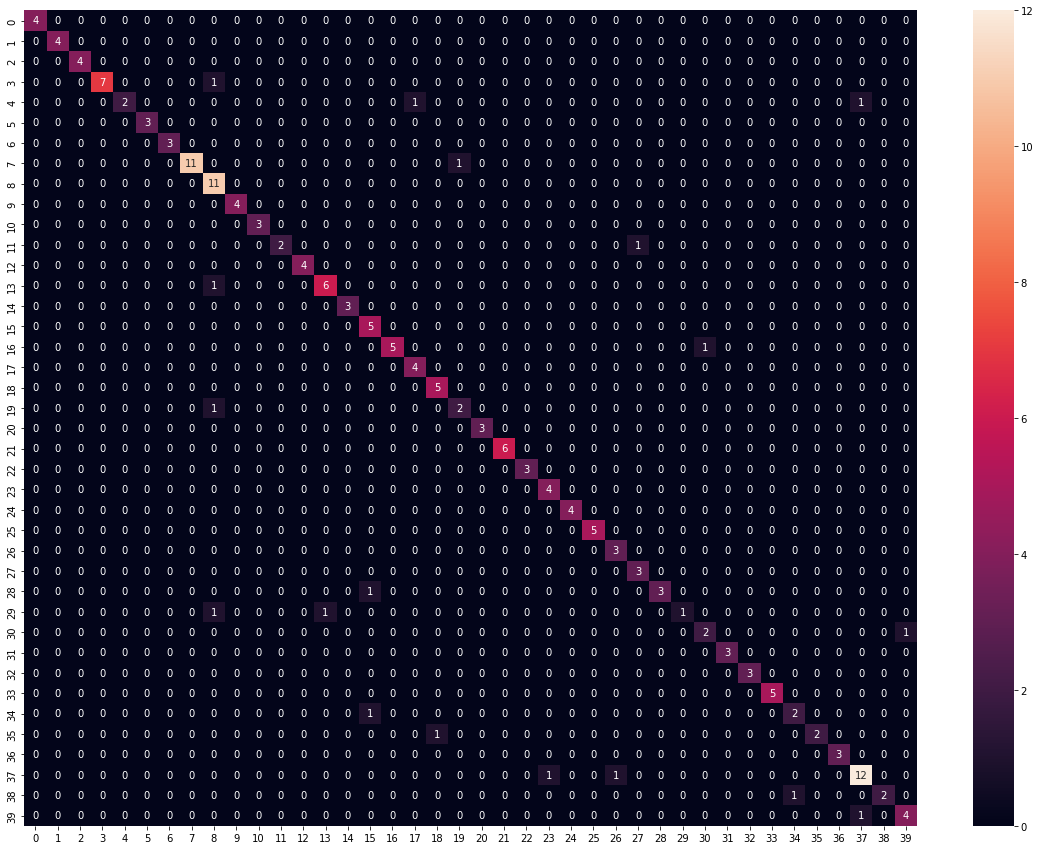

In [19]:
import seaborn as sns

val_lfw_dataset.set_training_mode("one")
val_lfw_dataset.enable_preprocess(True)
preds,targets,test_acc,score_f1 = test(classifier,val_loader, verbose=False)

print("\nTest accuracy :", test_acc)
print("F1 score :", score_f1)
cm = confusion_matrix(targets, preds)

plt.figure(figsize=(20,15))
sns.heatmap(cm, annot=True)
plt.show()

On remarque que le score macro average F1 est proche de l'exactitude. Cela permet de montrer que le modèle obtient de bonnes performances même pour les classes minoritaires. Cette observation semble être confirmée avec la matrice de confusion où la plupart des éléments sont concentrés sur la diagonale.

Chargement du modèle préentrainé

In [30]:
pretrained_model.load_state_dict(torch.load("pretrained_classifier_vgg16.pt",map_location=device))

<All keys matched successfully>

Nous commençons par charger le modèle ad hoc entraîné, puis on vérifie ses performances.

100%|██████████| 6/6 [00:15<00:00,  2.64s/it]



Test accuracy : 0.9453551912568307
F1 score : 0.9436740463642638


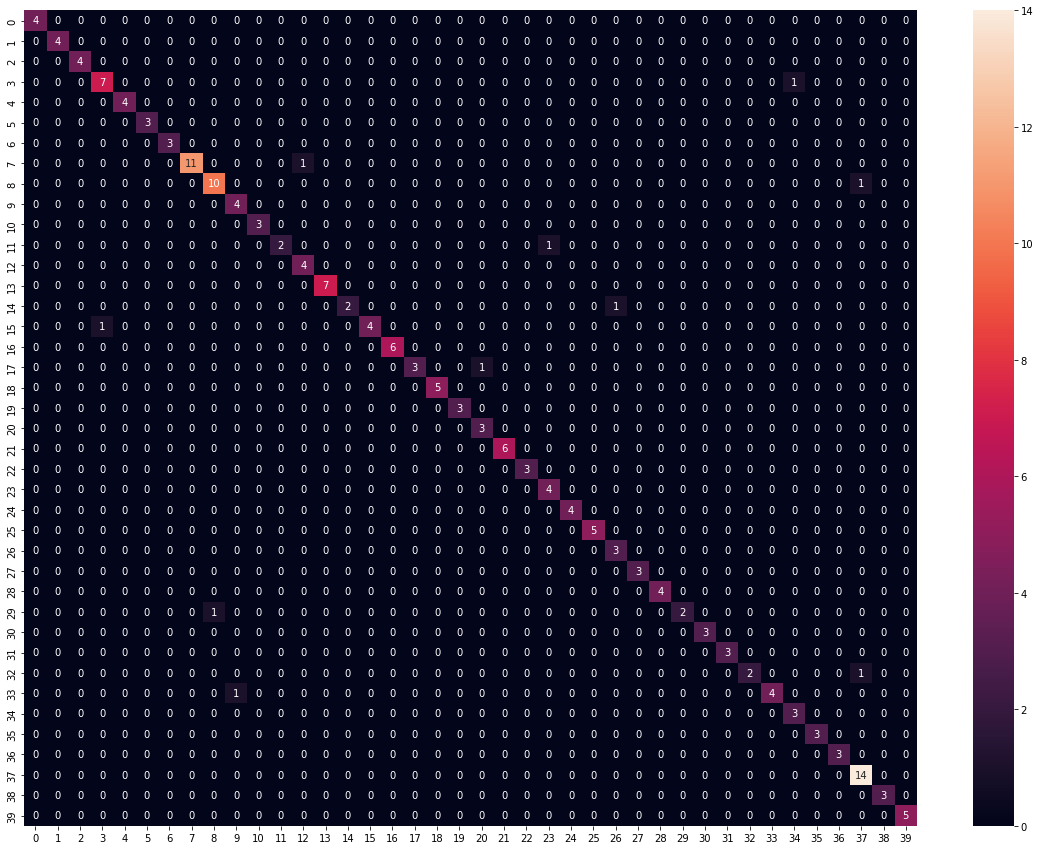

In [31]:
import seaborn as sns

val_lfw_dataset.set_training_mode("one")
val_lfw_dataset.enable_preprocess(True)
preds,targets,test_acc,score_f1 = test(pretrained_model,val_loader, verbose=False)

print("\nTest accuracy :", test_acc)
print("F1 score :", score_f1)
cm = confusion_matrix(targets, preds)

plt.figure(figsize=(20,15))
sns.heatmap(cm, annot=True)
plt.show()

Le score F1 ainsi que la matrice de confusion semblent confirmer que le modèle pré-entrainé obtient de meilleurs performances que le modèle ad hoc. Outre le pré-entrainement, ces performances peuvent aussi être expliquées par le fait que le modèle pré-entrainé (vgg16) possèdent plus de paramètres et donc plus de capacité que le modèle ad hoc.

-------------------------------

Concernant les attaques, je me suis concentré sur des attaques *white-box*, c'est-à-dire que l'on suppose que le modèle adverse $A$ a accès aux paramètres du modèle.

### Attaques implémentées

J'ai dans un premier temps implémenté l'attaque FGSM.

In [19]:
def fgsm(model, images, labels, device,epsilon=0.3) :
    """Application d'une attaque FGSM sur un batch d'images

    Paramètres:
        model: modèle à attaquer    
        images: images à attaquer
        labels: labels d'origine
        device : cpu or cuda
        epsilon: budget de perturbation 
    Renvoie: 
        perturbed_image : images attaquées
    """
    loss = nn.CrossEntropyLoss()
    
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True
            
    outputs = model(images)
    
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    
    perturbed_image = images + epsilon*images.grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

Ensuite, j'ai mis en place l'attaque *projected gradient descent* (PGD) non ciblée. Il s'agit de l'equivalent d"une méthode FGSM (Fast Gradient Sign) mais appliquée de façon itérative.

In [20]:
def PGD_linf(classifier,criterion, images, labels, device, epsilon=0.3, alpha=2/255, n_iter=40) :
    '''
    Application d'une attaque PGD sur un batch d'images

    Paramètres:
        model: modèle à attaquer     
        images:  images à attaquer
        labels: labels d'origine
        alpha: step size
        epsilon: budget de perturbation  
        n_iter:nombre d'itérations de l'algorithme PGD
    Renvoie: 
        images : images attaquées
    '''
    images = images.to(device)
    labels = labels.to(device)
    # loss_fn = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(n_iter) :    
        images.requires_grad = True
        outputs = classifier(images)

        classifier.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()            

    return images

Enfin, j'ai implémenté la méthode d'attaque [DeepFool](https://arxiv.org/abs/1511.04599).

In [21]:
def deepfool(X, model, device,num_classes=10, max_iter = 10):
    """
    Application d'une attaque DeepFool sur un batch d'images

    Paramètres:
        X: images à attaquer
        model: modèle à attaquer
        device : cpu or cuda
        num_classes : nombre de classes
        max_iter: nombre maximum d'itération de l'algorithme DeepFool
    Renvoie: 
        perturbed_images : images attaquées
        
    """
    model.eval()
    list_pertubed_imgs = []
    
    for num,x in enumerate(X):  
      x = x.unsqueeze(0)   
      with torch.no_grad(): 
        f_classifier = model(x)
        r = torch.zeros_like(x)

        # classe initiale prédite par le modèle
        k_x0 = torch.argmax(f_classifier[0]).item()

        classes = list(range(num_classes))
        classes.remove(k_x0)


      x_i = torch.tensor(x, requires_grad=False)


      cpt = 0
      while True:
        l_values = []
        wk_values = []
        wk_values2 = []
        x_i.requires_grad = True

        # Calcul de fk_x0
        f_classifier = model(x_i)
        # Calcul de grad_fk_x0
        selector = torch.zeros_like(f_classifier)
        selector[0][k_x0] = 1
        f_classifier.backward(selector)
        grad_fk_x0 = x_i.grad.data[0]
        fk_x0 = f_classifier[0][k_x0]

        x_i = x_i.detach()


        for i,k in enumerate(classes):
          x_i.requires_grad = True
          f_classifier = model(x_i)

          # Calcul de grad_fk_xi
          selector = torch.zeros_like(f_classifier)
          selector[0][k] = 1
          f_classifier.backward(selector)

          grad_fk_xi = x_i.grad.data[0]
          x_i = x_i.detach()

          # Calcul de fk_xi
          fk_xi = f_classifier[0][k]

          with torch.no_grad():

            #Calcul de wk'
            wk = grad_fk_xi - grad_fk_x0
            wk_values.append(wk)

            #Calcul de fk'          
            fk = fk_xi-fk_x0

            #norme p = 2
            l_values.append(torch.abs(fk)/torch.norm(wk,p=2))
            wk_values2.append(torch.norm(wk,p=2))

        with torch.no_grad():
            l = torch.argmin(torch.tensor(l_values)).item()
            r_i = l_values[l]*wk_values[l]/wk_values2[l]
            x_i = x_i + r_i

            r += r_i

            f_classifier = model(x_i)
            k_xi = torch.argmax(f_classifier[0]).item()

            if k_xi != k_x0:
              break

            cpt += 1

            if cpt > max_iter:
              break
        

      x_r = x + r
      list_pertubed_imgs.append(x_r)

    perturbed_images = torch.cat(list_pertubed_imgs,dim=0)   

    return perturbed_images

### Effet des attaques

Une attaque est un bruit $B_{pert}$ telle que la différence entre l'image perturbée $I_{pert} = I_{origin} + B_{pert}$ et l'image d'origine $I_{origin}$ ne soit pas perceptible à l'oeil nu. Pour mesurer l'ecart entre $I_{pert}$ et $I_{origin}$, il faut utiliser une norme. Pour ce projet, j'ai choisi d'utiliser la norme infini $||x||_{∞} = max(|x_1|,|x_2|,...,|x_n|)$. En d'autres termes, pour chaque pixel, la valeur absolue de la perturbation est limitée à un certain seuil. Ce seuil est le budget que l'on autorise pour l'attaque. 

Nous allons dans un premier temps observer l'effet d'une attaque sur une image. Ici, il s'agit de l'attaque PGD.

In [22]:
def PGD_linf_attack_effect(model,criterion,images,targets,epsilons,alpha=1/255,n_iter=10,figsize=(15,8),plot=True):
  plt.figure(figsize=figsize)
  for i, epsilon in enumerate(epsilons):
    if plot:
      plt.subplot(1,len(epsilons),i+1)
      plt.gca().set_title(f"budget (l-inf) : {np.round(epsilon,3)}")
    attacked_images = PGD_linf(model, criterion,images, targets, device, epsilon, alpha=alpha, n_iter=n_iter)

    if plot:
      plt.imshow(attacked_images[0].cpu().permute(1,2,0))
  
  if plot:  
    plt.show()

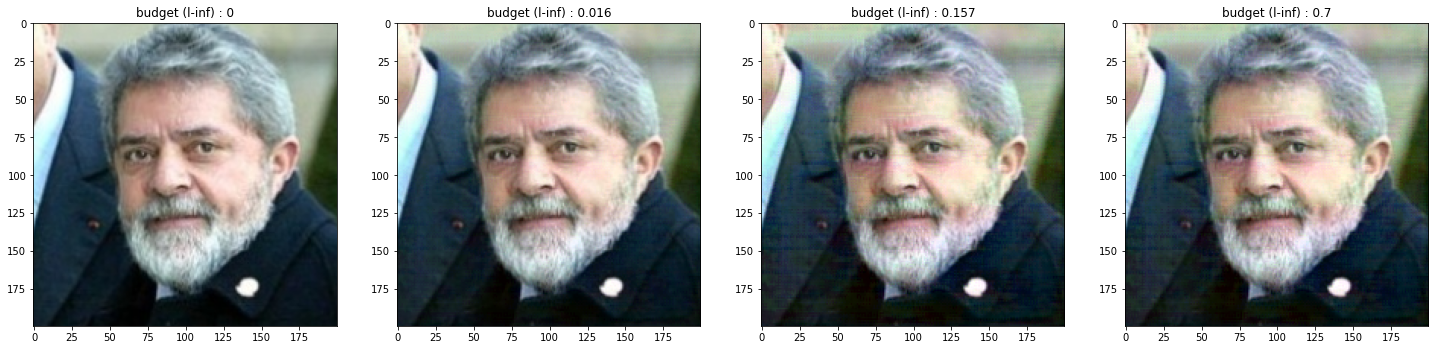

In [36]:
val_lfw_dataset.set_training_mode("one")
val_lfw_dataset.enable_preprocess(True)

images, targets = next(iter(val_loader))
image_to_attack = images[0].unsqueeze(0)
targets = targets[0].unsqueeze(0)

epsilons = [0, 4/255, 40/255, 0.7]

criterion = nn.CrossEntropyLoss()

PGD_linf_attack_effect(classifier,criterion,image_to_attack,targets,epsilons,figsize=(25,9))

Les valeurs des pixels d'une image (non pré-traitée) sont comprises entre 0 et 1. On remarque qu'une attaque PGD avec 10 itérations et un budget en norme infinie fixée à 0.02 (4/255) n'est pas perceptible à l'oeil. Au contraire, des attaques avec un budget de 0.16 (40/255) et 0.7 sont clairement visibles. 

Il est à noter que la tranformation RandomCrop fait que l'image est rognée et un zoom est appliqué lors du redimensionnement de l'image. Les attaques sont donc en théorie plus facile à détectée avec le zoom.

Dans la suite du projet, nous allons fixer le budget de perturbation à $ϵ = 4/255 ≈ 0.016$ en norme $p=∞$.

In [23]:
def plot_examples(examples, titles,correctness, size=(20,15)):
  """Affichage d'un ensemble d'images

    Paramètres:
        examples : images à afficher  
        title : titre de la figure
  """

  plt.figure(figsize=size)
  num_examples = len(examples)
  cnt = 0
  for j,title in enumerate(titles):
    cnt += 1
    plt.subplot(1,num_examples,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    ex = examples[j]
    plt.imshow(ex.permute(1,2,0))
    t = plt.title(title)
    if correctness[j]:
      plt.setp(t, color='g')
    else:
      plt.setp(t, color='r')

  plt.show()


def pgd_attack_effect_on_accuracy(model,criterion, device, dataloader,params):
    '''
    Application d'une attaque PGD sur le dataloader et évaluation du modèle 
    sur les images attaquées

    Paramètres:
        model: le classifieur à attaquer    
        device : PyTorch device
        dataloader: dataloader avec images et labels
        epsilon: budget de perturbation  
        alpha: Taille d'un pas de l'attaque PGD
        params : autres paramètres

    Renvoie : epsilons, accuracies
    '''
    # loss_fn = nn.CrossEntropyLoss()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()

    epsilons = []
    accuracies = []

    for X, y in dataloader:
      saved_examples = X[:params["num_exemples"]]
      saved_y = y[:params["num_exemples"]]



    for epsilon in tqdm(params["epsilons"]):
        test_loss = 0
        correct = 0

        print(f"Epsilon : {epsilon}")
        for X, y in dataloader:

            X = X.to(device)
            y = y.to(device)

            test_exemples = X[:params["num_exemples"]].detach().cpu()

            # Attaque
            perturbed_data = PGD_linf(model,criterion, X, y,device,
                                        epsilon=epsilon,
                                    alpha=params["alpha"],
                                    n_iter=params["n_iter"])

            pred = model(perturbed_data)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()



        
        
        # Attaque exemples
        if params["plot_examples"]:
          perturbed_data = PGD_linf(model,criterion,
                                    saved_examples.to(device), 
                                    saved_y.to(device),
                                    device,
                                          epsilon=epsilon,
                                      alpha=params["alpha"],
                                      n_iter=params["n_iter"])
          
          pred = model(perturbed_data)        
          correctness = pred.argmax(1).cpu() == saved_y
          predictions = [idx_to_class[idx.item()] for idx in pred.argmax(1)]
          predictions = predictions[:params["num_exemples"]]
          correctness = correctness[:params["num_exemples"]] 
          plot_examples(perturbed_data.cpu() ,predictions,correctness)

        test_loss /= num_batches
        correct /= size

        epsilons.append(epsilon)
        accuracies.append(100*correct)
        print(
            f"Accuracy: {(100*correct):>0.1f}% \n"
        )        
    return epsilons, accuracies

  0%|          | 0/2 [00:00<?, ?it/s]

Epsilon : 0


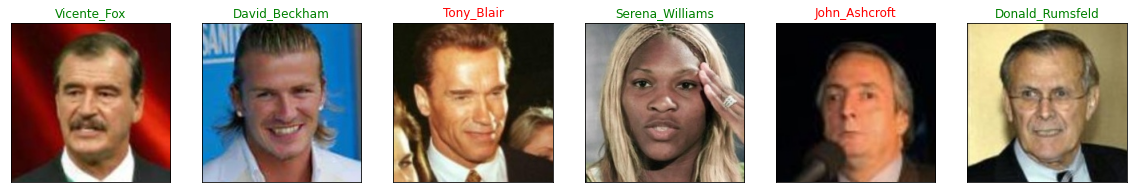

 50%|█████     | 1/2 [02:17<02:17, 137.21s/it]

Accuracy: 90.2% 

Epsilon : 0.01568627450980392


Error: Canceled future for execute_request message before replies were done

In [24]:
import gc

params = {
    "epsilons" : [0, 4/255],
    "n_iter" : 10,
    "alpha":  1/255, # step size
    "num_exemples": 6,
    "denoiser": None,
    "noise" : None,
    "plot_examples": True
}

val_lfw_dataset.enable_preprocess(True)


criterion = nn.CrossEntropyLoss()
epsilons, accuracies = pgd_attack_effect_on_accuracy(classifier, criterion, device, val_loader,params)

La première ligne correspond à des images non attaquées ($ϵ=0$). Les labels en vert correspondent aux images correctement classées.

La deuxième ligne correspond à des images attaquées avec PGD.

On remarque qu'avec un budget de 4/255 en norme $∞$, pour une attaque PGD à 10 itérations, le modèle ad hoc est passé d'une accuracy de 89.1% à une accuracy à 1.1%. La perturbation engendrée par l'attaque ne semble pas visible à l'oeil nu.

----------------------------

Nous allons maintenant appliquer l'attaque PGD sur le modèle pré-entrainé :

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/2 [00:00<?, ?it/s]

Epsilon : 0


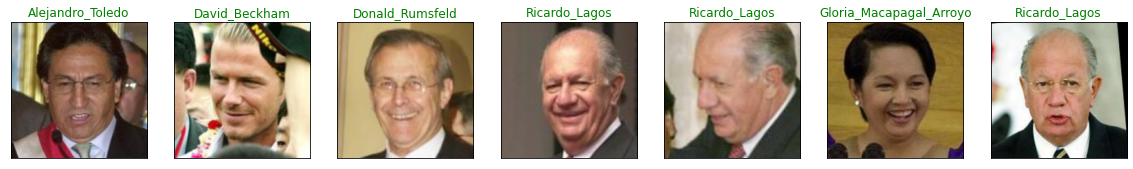

 50%|█████     | 1/2 [00:24<00:24, 24.94s/it]

Accuracy: 94.5% 

Epsilon : 0.01568627450980392


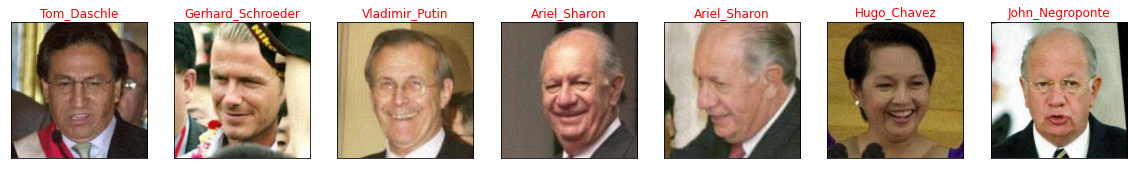

100%|██████████| 2/2 [00:50<00:00, 25.29s/it]

Accuracy: 14.8% 



In [93]:
params = {
    "epsilons" : [0,4/255],
    "n_iter" : 10,
    "alpha":  1/255, # step size
    "num_exemples": 7,
    "denoiser": None,
    "noise" : None,
    "plot_examples": True

}

val_lfw_dataset.enable_preprocess(True)
criterion = nn.CrossEntropyLoss()
epsilons, accuracies = pgd_attack_effect_on_accuracy(pretrained_model, criterion, device, val_loader,params)

On remarque qu'avec un budget de 4/255 en norme $∞$, pour une attaque PGD à 10 itérations, le modèle pré-entrainé est passé d'une accuracy de 94.5% à une accuracy à 14.8%. La perturbation engendrée par l'attaque ne semble pas visible à l'oeil nu.

En comparant avec le modèle ad hoc, il semble que le modèle pré-entrainé (vgg16) esst a priori plus robuste aux attaques adverses.

--------------------------------------------

J'ai également mis en place une attaque PGD ciblée, c'est-à-dire qu'on peut choisir 

In [95]:
def target_PGD_linf(target_class,classifier,criterion, images, labels, device, epsilon=0.3, alpha=2/255, n_iter=40) :
    '''
    Application d'une attaque PGD ciblée (l_infinity)
    '''
    images = images.to(device)

    # target_labels = torch.zeros_like(labels)


    target_labels = torch.ones_like(labels)*target_class
    target_labels = target_labels.to(device)

    # labels = labels
    # loss_fn = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(n_iter) :    
        images.requires_grad = True
        outputs = classifier(images)


        classifier.zero_grad()
        loss = criterion(outputs, target_labels)
        loss.backward()

        adv_images = images - alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()            

    return images


def targeted_pgd_attack_effect_on_accuracy(target_class,model,criterion, device, dataloader,params):
    '''
    Application d'une attaque PGD ciblée sur un dataloader et 
    évaluation de la robustesse du modèle
    '''
    # loss_fn = nn.CrossEntropyLoss()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()

    epsilons = []
    accuracies = []

    for X, y in dataloader:
      saved_examples = X[:params["num_exemples"]]
      saved_y = y[:params["num_exemples"]]



    for epsilon in tqdm(params["epsilons"]):
        test_loss = 0
        correct = 0


        print(f"Epsilon : {epsilon}")
        for X, y in dataloader:

            X = X.to(device)
            y = y.to(device)

            test_exemples = X[:params["num_exemples"]].detach().cpu()

            # Attaque
            perturbed_data = target_PGD_linf(target_class,
                                             model,
                                             criterion,
                                             X,
                                             y,
                                             device,
                                        epsilon=epsilon,
                                    alpha=params["alpha"],
                                    n_iter=params["n_iter"])

            if params["noise"]:
                perturbed_data = params["noise"](perturbed_data)            


            if params["denoiser"]:
                perturbed_data = params["denoiser"](perturbed_data)

            pred = model(perturbed_data)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

       
        
        perturbed_data = target_PGD_linf(target_class,
                                             model,
                                             criterion,
                                              saved_examples.to(device), 
                                              saved_y.to(device),
                                             device,
                                        epsilon=epsilon,
                                    alpha=params["alpha"],
                                    n_iter=params["n_iter"])
        pred = model(perturbed_data)        
        correctness = pred.argmax(1).cpu() == saved_y
        predictions = [idx_to_class[idx.item()] for idx in pred.argmax(1)]
        predictions = predictions[:params["num_exemples"]]
        correctness = correctness[:params["num_exemples"]]        
        plot_examples(perturbed_data.cpu() ,predictions,correctness)

        test_loss /= num_batches
        correct /= size

        epsilons.append(epsilon)
        accuracies.append(100*correct)
        print(
            f"Accuracy: {(100*correct):>0.1f}% \n"
        )

        
    return epsilons, accuracies

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/2 [00:00<?, ?it/s]

Epsilon : 0


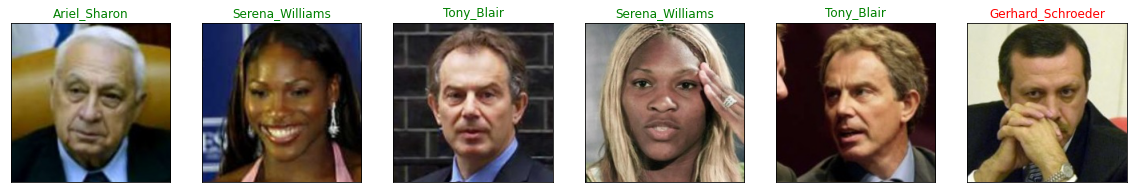

 50%|█████     | 1/2 [00:24<00:24, 25.00s/it]

Accuracy: 89.6% 

Epsilon : 0.01568627450980392


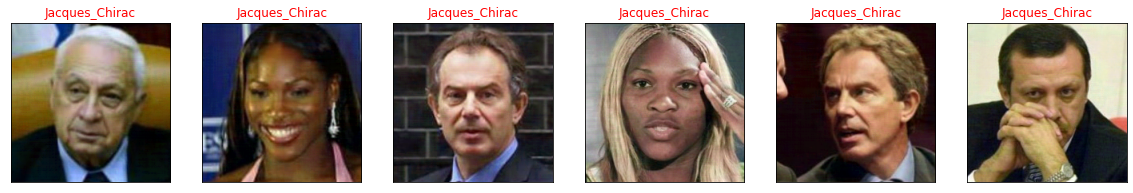

100%|██████████| 2/2 [00:50<00:00, 25.33s/it]

Accuracy: 7.1% 



([0, 0.01568627450980392], [89.61748633879782, 7.103825136612022])

In [96]:
val_lfw_dataset.set_training_mode("one")
val_lfw_dataset.enable_preprocess(True)

params = {
    "epsilons" : [0,4/255],
    "n_iter" : 20,
    "alpha":  1/255, # alpha infini
    "num_exemples": 6,
    "denoiser": None,
    "noise" : None
}

criterion = nn.CrossEntropyLoss()

# Target class
target_class = 15

targeted_pgd_attack_effect_on_accuracy(target_class,classifier,criterion, device, val_loader,params)

On remarque qu'avec un budget de 4/255 en norme $∞$, pour une attaque PGD ciblé à 10 itérations, le modèle ad hoc est passé d'une accuracy de 89.6% à une accuracy à 7.1%. On voit que toutes les images ont été identifiées comme étant Jacques Chirac, cela montre que l'attque ciblée fonctionne correctement.

La perturbation engendrée par l'attaque ne semble pas visible à l'oeil nu.

### Adversarial training

----------------

Dans la suite, le modèle ad hoc a été entrainé avec des attaques adverses (adversarial training) :

In [97]:
def adversarial_train_classifier(params,train_lfw_dataset, val_lfw_dataset, train_loader,val_loader, optimizer,classifier,criterion, save_path):
    """returns trained model"""   
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    train_lfw_dataset.enable_preprocess(True)
    train_lfw_dataset.set_training_mode("one")

    val_lfw_dataset.enable_preprocess(True)
    val_lfw_dataset.set_training_mode("one")

    
    for epoch in range(1, params["n_epochs"]+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        classifier.train()
        preds, targets = [] , []

        for batch_idx, (image,target) in tqdm(enumerate(train_loader)):
            
            image = image.to(device)
            target = target.to(device)

            #Attaque
            image = PGD_linf(classifier,criterion,
                                      image, 
                                      target,
                                      device,
                                      epsilon=params["epsilon"],
                                      alpha=params["alpha"],
                                      n_iter=params["n_iter"])


            optimizer.zero_grad()

            raw_logits = classifier(image)

            loss = criterion(raw_logits,target)
            loss.backward()
            optimizer.step()   
            train_loss += loss.item()

            with torch.no_grad():
              pred =   [x.item() for x in raw_logits.argmax(1)]
              target = [x.item() for x in target]

              preds.extend(pred)
              targets.extend(target)
          
        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(targets,preds)

        ###  VALIDATION
        with torch.no_grad():
          classifier.eval()

          for batch_idx, (image,target) in enumerate(val_loader):
              
              image = image.to(device)
              target = target.to(device)

              raw_logits = classifier(image)

              loss = criterion(raw_logits,target)
              valid_loss += loss.item()
              
          valid_loss /= len(val_loader.dataset)
        
          current_lr = optimizer.param_groups[0]['lr']
          scheduler.step(valid_loss)

          preds,targets,test_acc,score_f1 = test(classifier,val_loader)


          print(" ### Epoch: {}, lr = {}, train_acc = {},training loss = {},test_acc = {}, val_loss = {}".format(epoch, current_lr,train_acc, train_loss, test_acc,valid_loss))

In [98]:
EMB_DIM = 200

criterion = nn.CrossEntropyLoss().to(device)
# model = CNN_Classifier(train_num_classes,EMB_DIM).to(device)
robust_model = ModelAdHoc(class_num=train_num_classes,feature_dim=EMB_DIM).to(device)

In [ ]:
robust_model.load_state_dict(torch.load("robust_classifier_adhoc.pt",map_location=device))

In [ ]:
optimizer = optim.SGD([
        {'params': robust_model.parameters(), 'weight_decay': 5e-4},
        ] , 
                      lr=0.0001,
                      momentum=0.9,
                      weight_decay = 5e-4)

params = {
    "n_epochs":50,
    "epsilon":4/255,
    "alpha":1/255,
    "n_iter" : 10
}

adversarial_train_classifier(params,train_lfw_dataset,
                 val_lfw_dataset, 
                 train_loader,
                 val_loader, 
                 optimizer,robust_model,criterion, save_path)

In [41]:
# torch.save(robust_model.state_dict(), save_path+"robust_classifier_adhoc.pt")

### Performances des attaques et des modèles

Chargement des paramètres des modèles entraînés :

In [60]:
EMB_DIM = 200
criterion = nn.CrossEntropyLoss().to(device)
robust_model = ModelAdHoc(class_num=train_num_classes,feature_dim=EMB_DIM).to(device)
robust_model.load_state_dict(torch.load("robust_classifier_adhoc.pt",map_location=device))

model = ModelAdHoc(class_num=train_num_classes,feature_dim=EMB_DIM).to(device)
model.load_state_dict(torch.load("classifier_adhoc.pt",map_location=device))

model_with_noise = ModelAdHoc(class_num=train_num_classes,feature_dim=EMB_DIM).to(device)
model_with_noise.load_state_dict(torch.load("classifier_adhoc_with_noise.pt",map_location=device))

<All keys matched successfully>

In [ ]:
EPSILON_MAX = 8/255
N_EVAL = 8

params = {
    "epsilons" : np.linspace(0,EPSILON_MAX,N_EVAL),
    "n_iter" : 10,
    "alpha":  1/255, # step size
    "num_exemples": 8,
    "denoiser": None,
    "noise" : None,
    "plot_examples" : False
}

val_lfw_dataset.enable_preprocess(True)


criterion = nn.CrossEntropyLoss()
epsilons, normal_accuracies = pgd_attack_effect_on_accuracy(model, criterion, device, val_loader,params)
epsilons, noise_accuracies = pgd_attack_effect_on_accuracy(model_with_noise, criterion, device, val_loader,params)
epsilons, pretrained_accuracies = pgd_attack_effect_on_accuracy(pretrained_model, criterion, device, val_loader,params)
epsilons, robust_accuracies = pgd_attack_effect_on_accuracy(robust_model, criterion, device, val_loader,params)

(0.0, 0.03294117647058824)

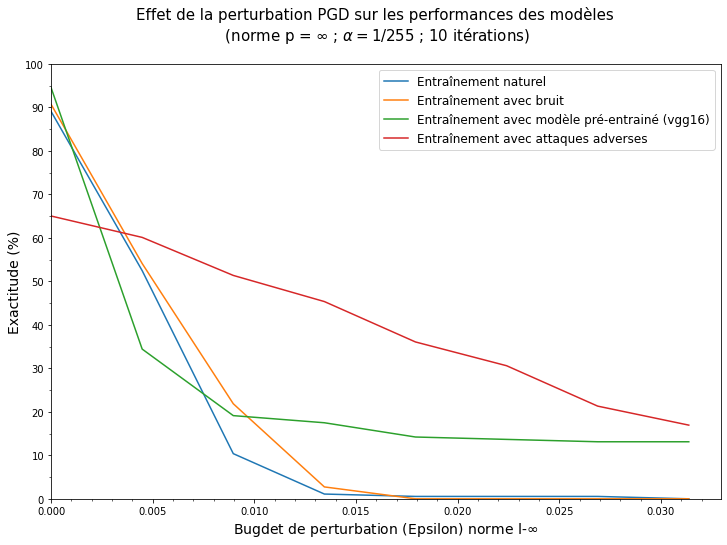

In [81]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
X_Y_LABEL_SIZE = 14
TITLE_SIZE = 15

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(epsilons,normal_accuracies)
ax.plot(epsilons,noise_accuracies)
ax.plot(epsilons,pretrained_accuracies)
ax.plot(epsilons,robust_accuracies)
plt.xlabel(r"Bugdet de perturbation (Epsilon) norme l-$\infty$",fontsize=X_Y_LABEL_SIZE)
plt.ylabel("Exactitude (%)",fontsize=X_Y_LABEL_SIZE)
fig.suptitle('Effet de la perturbation PGD sur les performances des modèles\n'+r' (norme p = $\infty$ ; $\alpha = 1/255$ ; 10 itérations)', fontsize=TITLE_SIZE)
ax.xaxis.set_major_locator(MultipleLocator(0.005))
ax.xaxis.set_minor_locator(MultipleLocator(0.001))


ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(["Entraînement naturel",
            "Entraînement avec bruit", 
            "Entraînement avec modèle pré-entrainé (vgg16)",
            "Entraînement avec attaques adverses"],loc=1, prop={'size': 12})

plt.ylim([0,100])
plt.xlim([0,EPSILON_MAX*1.05])

J'ai également affiché ci-dessous un exemple d'une image attaquée avec plusieurs budgets de perturbation :

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


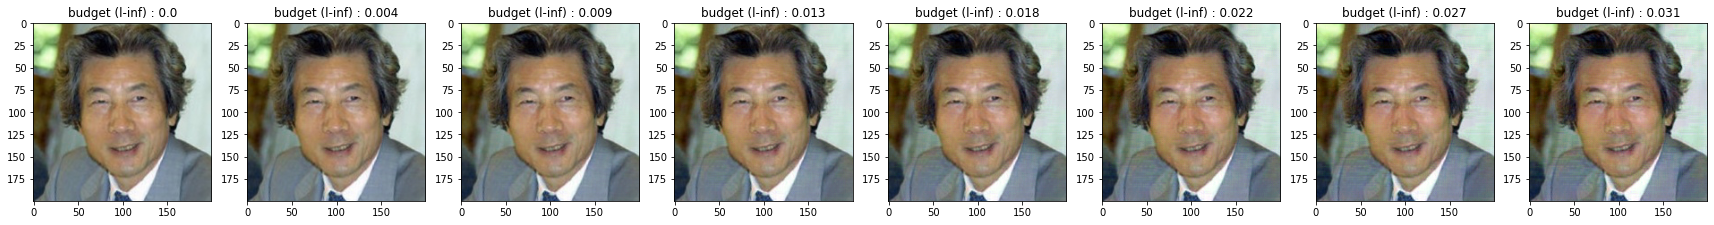

In [76]:
val_lfw_dataset.set_training_mode("one")
val_lfw_dataset.enable_preprocess(True)

images, targets = next(iter(val_loader))
image_to_attack = images[0].unsqueeze(0)
targets = targets[0].unsqueeze(0)

epsilons = np.linspace(0,EPSILON_MAX,N_EVAL)
criterion = nn.CrossEntropyLoss()

PGD_linf_attack_effect(model,criterion,image_to_attack,targets,epsilons,figsize=(30,20))

On remarque que le modèle entraîné avec attaques advserves (adversarial training) est plus robuste aux attaques que tous les autres modèles. Cependant, cette robustesse a été obtenu au prix d'une perte en accuracy du modèle quand $ϵ=0$. J'ai pu entraîné le modèle (adversarial training) jusqu'à ce qu'il obitenne une accuracy de 67%.

Le modèle ad hoc entraîné avec un bruit gaussien additif semble légèrement plus robuste que le modèle ad hoc classique. Enfin, comme observé précedemment, le modèle pré-entrainé semble plus robuste que le modèle ad hoc classique.

-----------------------------------

Il existe également d'autres méthodes de défense face aux attaques adverses que l'on aurait plus appliquer comme defense distillation.